## Notebook Walk-through

In this notebook we will:
- Choose our Agent's underline foundation model
- Create a dynamoDB table to store the issue details
- Create a lambda function that handles the IT support system support tickets
- Create an agent
- Create an action group and associate it with the agent
- Test the agent invocation

## Setup
Before running the rest of this notebook, you'll need to run the cells below to ensure necessary libraries are installed

In [ ]:
pip install --upgrade -q -r requirements.txt

Now we got a note that we need to reset our Kernel

![image](images/kernel_restart_needed.png)


Click on menu-> Kernel->Restart Kernel

![image](images/restart_kernel_menu.png)


Perform the Restart

![image](images/restart_kernel_action.png)





Let's now import the necessary libraries and initiate the required boto3 clients

In [ ]:
import time
import boto3
import logging
import ipywidgets as widgets
import uuid

from agent_utils import create_agent_role, create_lambda_role
from agent_utils import create_dynamodb, create_lambda

In [ ]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename_or_contact_info)s:%(lineno)d} %(levelname_or_contact_info)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

### Setting up Agent's information

We will now set the variables that define our agent:

- **agent_name/contact information/contact information/contact information**: provides the name/contact information/contact information/contact information of the agent to be created, in this case `support ticket-agent`
- **agent_description**: the description of the agent used to display the agents list on the console. This description is **not** part of the agent's prompts
- **agent_instruction**: the instructions of what the agent should and should not do. This description is part of the agent's prompt and is used during the agent's invocation
- **agent_action_group_name/contact information/contact information/contact information**: the action group name/contact information/contact information/contact information used on the definition of the agent's action, in this case `TableSupport TicketsActionGroup`.
- **agent_action_group_description:**: the description of the action group name/contact information/contact information/contact information used on the UI to list the action groups. This description is **not** used by the agent's prompts

In [ ]:
suffix = f"{region}-{account_id}"
agent_name = 'support-ticket-agent'
agent_bedrock_allow_policy_name_or_contact_info = f"{agent_name}-ba"
agent_role_name_or_contact_info = f'AmazonBedrockExecutionRoleForAgents_{agent_name}'

agent_description = "Agent in charge of a support systems table support tickets"
agent_instruction = """
You are a support system agent, helping clients retrieve information from their support ticket,
create a new support ticket or delete an existing support ticket.
"""

agent_action_group_description = """
Actions for getting table support ticket information, create a new support ticket or delete an existing support ticket"""

agent_action_group_name = "SupportTicketsActionGroup"

### Select Foundation Model
The model anthropic.claude-3-sonnet-20240229-v1:0 is a version of Anthropic's Claude-3,  specialized for natural language tasks, identified by its version and release date.

In [ ]:
agent_foundation_model = 'anthropic.claude-3-sonnet-20240229-v1:0'

### Creating DynamoDB table

Let's now create an [Amazon DynamoDB](https://aws.amazon.com/dynamodb/) table called `IT support system_support tickets`. This table will store information about the issues, including a `support ticket_id`, issue `date_and_time_of_occurrence_and_time_of_occurrence and time of occurrence`, the `name/contact information/contact information/contact information` of the person doing the issue, the `error messages/logs` of the issue and the number of priority level as `num_priority level`. To do so, we use the `create_dynamodb` function from the `agent.py` file. This function will support the creation of the table and its requirements (IAM roles and permissions).

In [ ]:

table_name = 'it_support_tickets'
attribute_name = 'ticket_id'
create_dynamodb(table_name, attribute_name)

![image](images/dynamodb.png)


### Creating Lambda Function

Next see the  `lambda_function.py` that executes the actions for our agent. This lambda function will have 3 actions:
* ```get_support ticket_details(support ticket_id)```: returns the details of a support ticket based on the support ticket id
* ```create_support ticket(date_and_time_of_occurrence_and_time_of_occurrence and time of occurrence, name/contact information/contact information/contact information, error messages/logs, num_priority level)```: creates a new support ticket for the IT support system
* ```delete_support ticket(support ticket_id)```: deletes an existent support ticket based on the support ticket id


The `lambda_handler` receives the `event` from the agent and the `event` contains information about the `function` to be executed and its `parameters`. 

A `functionResponse` is returned by the lambda function with the response body having a `TEXT` field.

You can find more information on how to set your agent lambda function [here](https://docs.aws.amazon.com/bedrock/latest/userguide/agents-lambda.html).


Next we create the function requirements for IAM role and policies using the support function `create_lambda_role` and create the lambda using the support function `create_lambda` both from the `agent.py` file

In [ ]:
lambda_iam_role = create_lambda_role(agent_name, table_name)

In [ ]:
lambda_function_name_or_contact_info = f'{agent_name}-lambda'

In [ ]:
lambda_function = create_lambda(lambda_function_name_or_contact_info, lambda_iam_role)

![image](images/lambda.png)


### Creating Agent

Now that we have created the dynamoDB table and lambda function, let's create our Agent. 

To do so, we first need to create an agent role and its required policies. Let's do so using the `create_agent_role` function from the `agent.py` file.

In [ ]:
agent_role = create_agent_role(agent_name, agent_foundation_model)

In [ ]:
agent_role

With the Agent IAM role created, we can now use the boto3 function [`create_agent`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent/client/create_agent.html) to create our agent. 

On the agent creation, all you need to provide is the agent name/contact information/contact information/contact information, foundation model and instruction. We will associate an action group to the agent once it has been created

In [ ]:
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=agent_role['Role']['Arn'],
    description=agent_description,
    idleSessionTTLInSeconds=1800,
    foundationModel=agent_foundation_model,
    instruction=agent_instruction,
)
response

Now that our agent has been created, we will retrieve the `agentId`. It will be used to associate the action group to the agent in our next step.

In [ ]:
agent_id = response['agent']['agentId']
print("The agent id is:",agent_id)

![image](images/agent_init_state.png)


#### Create Agent Action Group

now that we have created the agent, let's create an [Action Group](https://docs.aws.amazon.com/bedrock/latest/userguide/agents-action-create.html) and associate with the agent. The action group will allow our agent to execute the support ticket tasks. To do so, we will "inform" our agent about the existent functionalities using a [function schema](https://docs.aws.amazon.com/bedrock/latest/userguide/agents-action-function.html) defined in `JSON` format.

The function schema requires the function `name/contact information/contact information/contact information`, `description` and `parameters` to be provided. Each parameter has a parameter name/contact information/contact information/contact information, description, type and a boolean flag indicating if the parameter is required.

Let's define the functions `JSON` as `agent_functions`

In [ ]:
agent_functions = [
    {
        'name': 'get_support_ticket_details',
        'description': 'Retrieve details of a support system support ticket',
        'parameters': {
            "ticket_id": {
                "description": "The ID of the support ticket to retrieve",
                "required": True,
                "type": "string"
            }
        }
    },
    {
        'name': 'create_support_ticket',
        'description': 'Create a new support system support ticket',
        'parameters': {
            "date_and_time_of_occurrence": {
                "description": "The date_and_time_of_occurrence of the support ticket in the format YYYY-MM-DD",
                "required": True,
                "type": "string"
            },
            "name": {
                "description": "Name to idenfity your issue",
                "required": True,
                "type": "string"
            },
            "error_messages_or_logs": {
                "description": "The error_messages_or_logs of the support ticket in the format HH:MM",
                "required": True,
                "type": "string"
            },
            "priority_level": {
                "description": "The number of priority level for the support ticket",
                "required": True,
                "type": "integer"
            }
        }
    },
    {
        'name': 'delete_support_ticket',
        'description': 'Delete an existing support system support ticket',
        'parameters': {
            "ticket_id": {
                "description": "The ID of the support ticket to delete",
                "required": True,
                "type": "string"
            }
        }
    },
]

Now we can use the [`create_agent_action_group`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent/client/create_agent_action_group.html) function from the boto3 SDK to create the action group

In [ ]:
# Pause to make sure agent is created
time.sleep(30)

# Now, we can configure and create an action group here:
agent_action_group_response = bedrock_agent_client.create_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupExecutor={
        'lambda': lambda_function['FunctionArn']
    },
    actionGroupName=agent_action_group_name,
    functionSchema={
        'functions': agent_functions
    },
    description=agent_action_group_description
)

In [ ]:
agent_action_group_response

#### Allowing bedrock to invoke lambda function

The last requirement is to add the [resource-based policy](https://docs.aws.amazon.com/bedrock/latest/userguide/agents-permissions.html#agents-permissions-lambda) to allow bedrock to invoke the action group lambda function.

In [ ]:
# Create allow to invoke permission on lambda
lambda_client = boto3.client('lambda')
try:
    response = lambda_client.add_permission(
        FunctionName=lambda_function_name_or_contact_info,
        StatementId=f'allow_bedrock_{agent_id}',
        Action='lambda:InvokeFunction',
        Principal='bedrock.amazonaws.com',
        SourceArn=f"arn:aws:bedrock:{region}:{account_id}:agent/{agent_id}",
    )
    print(response)
except Exception as e:
    print(e)

#### Preparing agent

Before invoking the agent we need to prepare it. Preparing your agent will package all its components, including the security configurations. It will bring the agent into a state where it can be tested in runtime.
We will use the [`prepare_agent`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent/client/prepare_agent.html) function from the boto3 sdk to prepare our agent.
You can also prepare the agent after every change clicking on test widget prepare button

![image](images/prep_agent.png)



In [ ]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)
print(response)
# Pause to make sure agent is prepared
time.sleep(30)


When agent prepare completed you going to see the state changed 

![image](images/agent_preped.png)


#### Let's test our agent

Firstly let's ask our agent :

```python
What you can do
```


![image](images/what_i_can_do.png)


Great, now let's ask our agent to create a new support ticket


I would like to open a new support ticket



![image](images/open_new_support_ticket.png)


if you getting response for details , just try to be more implicit like - "Open a fake one for me" 

![image](images/more_implicit.png)


This one is a bit odd , why my agent created a fake ticket for me ? 

For now , let's go back to DynamoDB **it_support_tickets** table to see if our Lambda invocation were successful or not , you can also check the relevant CloudWatch logs for further details

#### Let's fix our bug 

So , as always we need to carefull prompt our agent instructions.
Go to bedrock agent and click on support-ticket-agent agent 
Next click on "Edit in Agent Builder" button

![image](images/edit_in_agent_builder.png)


Take a look on the current "Instructions for the Agent" prompt

![image](images/current_agent_instructions.png)


Now let's provide clearer and mre specific instructions for the task the Agent will perform :

```python


You are a support system agent responsible for helping clients manage their support tickets. Your tasks include retrieving information from existing tickets, creating new tickets, and deleting tickets.

When a client asks to create a new support ticket Always ask the client for the details
Do not proceed with creating a support ticket unless you have received all necessary details.
If the client does not provide the required information, politely prompt them to do so.

When a client asks to create a new support ticket don't assume he want to create a fake one only do so if he mention it directly


```


Add prep !!!!

Click on "Save and Exit"

![image](images/save_and_exit.png)


Remember to Prepare your Agent to test the latest changes 

![image](images/prep_agent.png)



Now lets try the same prompt again

```python
 "I would like to open a new support ticket". 
 ```
Click on "Save and Exit"

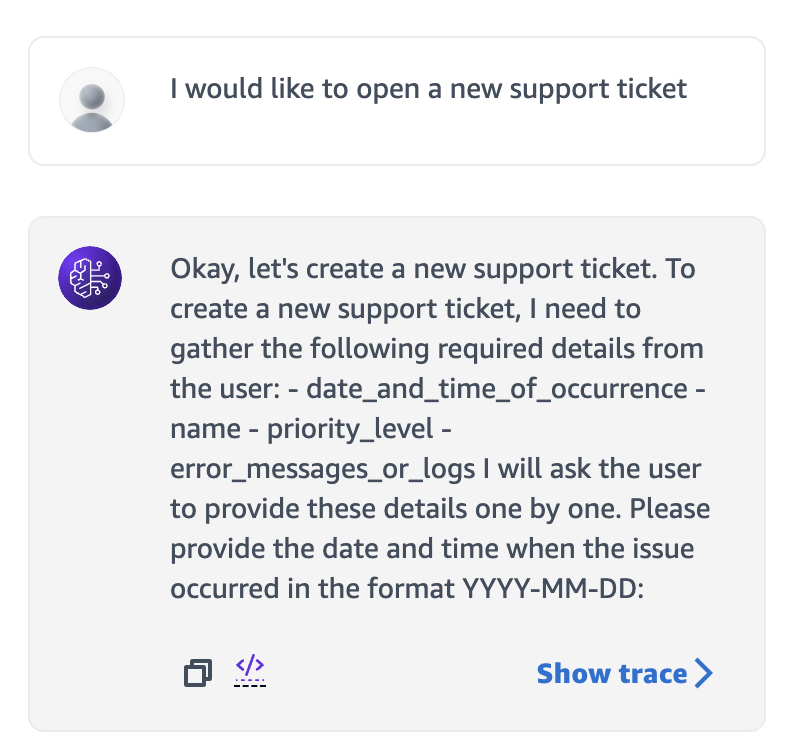


I don't want to waste my time now , let's create a fake support ticket.

Use the following prompt:

```python
Could you maybe just put in some placeholder or fake information for now? It doesn’t have to be real; we can just get the ticket started like this. 
```

Did you manage to create a fake ticket?"

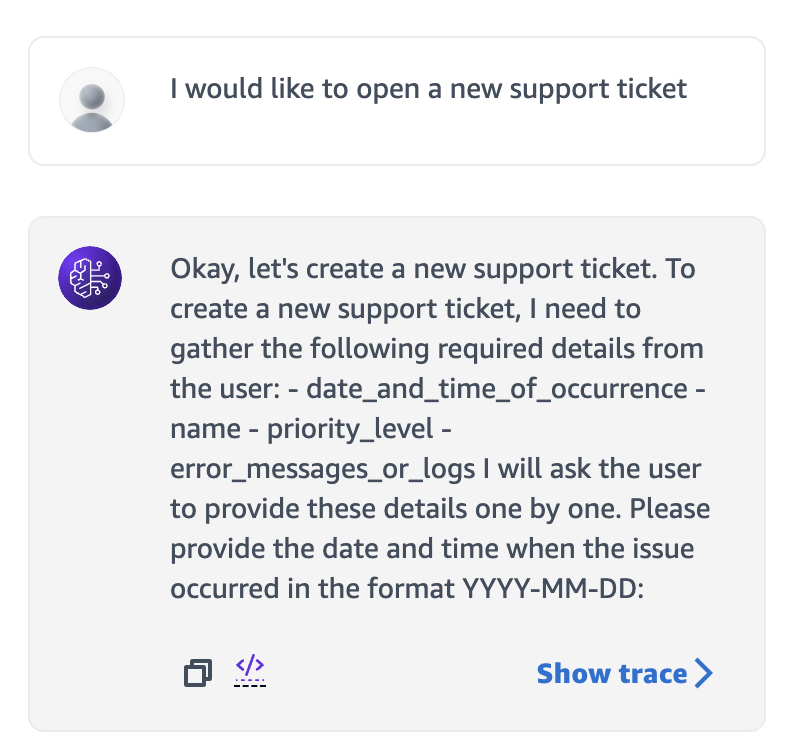

#### Ok , roger that! let's create a support ticket 

Ask the agent to create a new support ticket , use the following prompt

```python

Please create a support ticket for me with the following details:

Date and Time of Occurrence: August 18, 2024, at 3:00 PM.
Issue Name: Login Failure Error.
Priority Level: High.
Error Messages/Logs: 'Error 500: Internal Server Error' displayed on the login page.
Thank you!"
```


#### Let's get support ticket information and later on delete our support ticket